# 02. データ前処理と特徴量エンジニアリング (Preprocessing and Feature Engineering)

## 概要
生のデータを機械学習モデルが扱える形式に変換する方法を学びます。

## 学習目標
- データのスケーリングと正規化ができる
- 欠損値を適切に処理できる
- カテゴリカル変数をエンコードできる
- 新しい特徴量を作成できる
- 次元削減の手法を理解できる

In [ ]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, 
    LabelEncoder, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 日本語フォント設定
def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
np.random.seed(42)

print("Setup complete")
if font_used:
    print(f"Japanese font: {font_used}")

## 1. データスケーリング

### なぜスケーリングが必要か？

機械学習アルゴリズムの多くは、特徴量のスケールに敏感です。

**スケーリングが重要な理由:**
- ニューラルネットワーク: 学習の収束速度に影響
- SVM: 距離ベースの計算に影響
- k-NN: ユークリッド距離の計算に影響
- PCA: 分散が大きい特徴量に偏る

### 主なスケーリング手法

1. **StandardScaler（標準化）**
   - 平均0、標準偏差1に変換
   - 式: z = (x - μ) / σ
   - 最もよく使われる

2. **MinMaxScaler（正規化）**
   - 0〜1の範囲に変換
   - 式: x' = (x - min) / (max - min)
   - 外れ値に敏感

3. **RobustScaler（ロバスト標準化）**
   - 中央値と四分位範囲を使用
   - 外れ値に頑健

In [38]:
# サンプルデータ生成
np.random.seed(42)
data = {
    'age': np.random.randint(20, 70, 100),
    'salary': np.random.randint(30000, 150000, 100),
    'score': np.random.uniform(0, 100, 100)
}
df = pd.DataFrame(data)

# 外れ値を追加
df.loc[0, 'salary'] = 500000
df.loc[1, 'age'] = 95

print("元のデータの統計:")
print(df.describe())

元のデータの統計:
              age         salary       score
count  100.000000     100.000000  100.000000
mean    44.540000   95165.990000   51.525985
std     15.315154   53851.241748   27.922839
min     20.000000   30206.000000    0.052038
25%     33.000000   59376.500000   26.875450
50%     43.000000   92607.500000   50.850643
75%     58.000000  119596.750000   72.450897
max     95.000000  500000.000000   99.774049


/var/folders/6s/q776k1nj6rn9vjn979kn090w0000gn/T/ipykernel_96537/3392922152.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_scaled, labels=df.columns)
/var/folders/6s/q776k1nj6rn9vjn979kn090w0000gn/T/ipykernel_96537/3392922152.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_scaled, labels=df.columns)
/var/folders/6s/q776k1nj6rn9vjn979kn090w0000gn/T/ipykernel_96537/3392922152.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_scaled, labels=df.columns)
/var/folders/6s/q776k1nj6rn9vjn979kn090w0000gn/T/ipykernel_96537/3392922152.py:19: Matpl

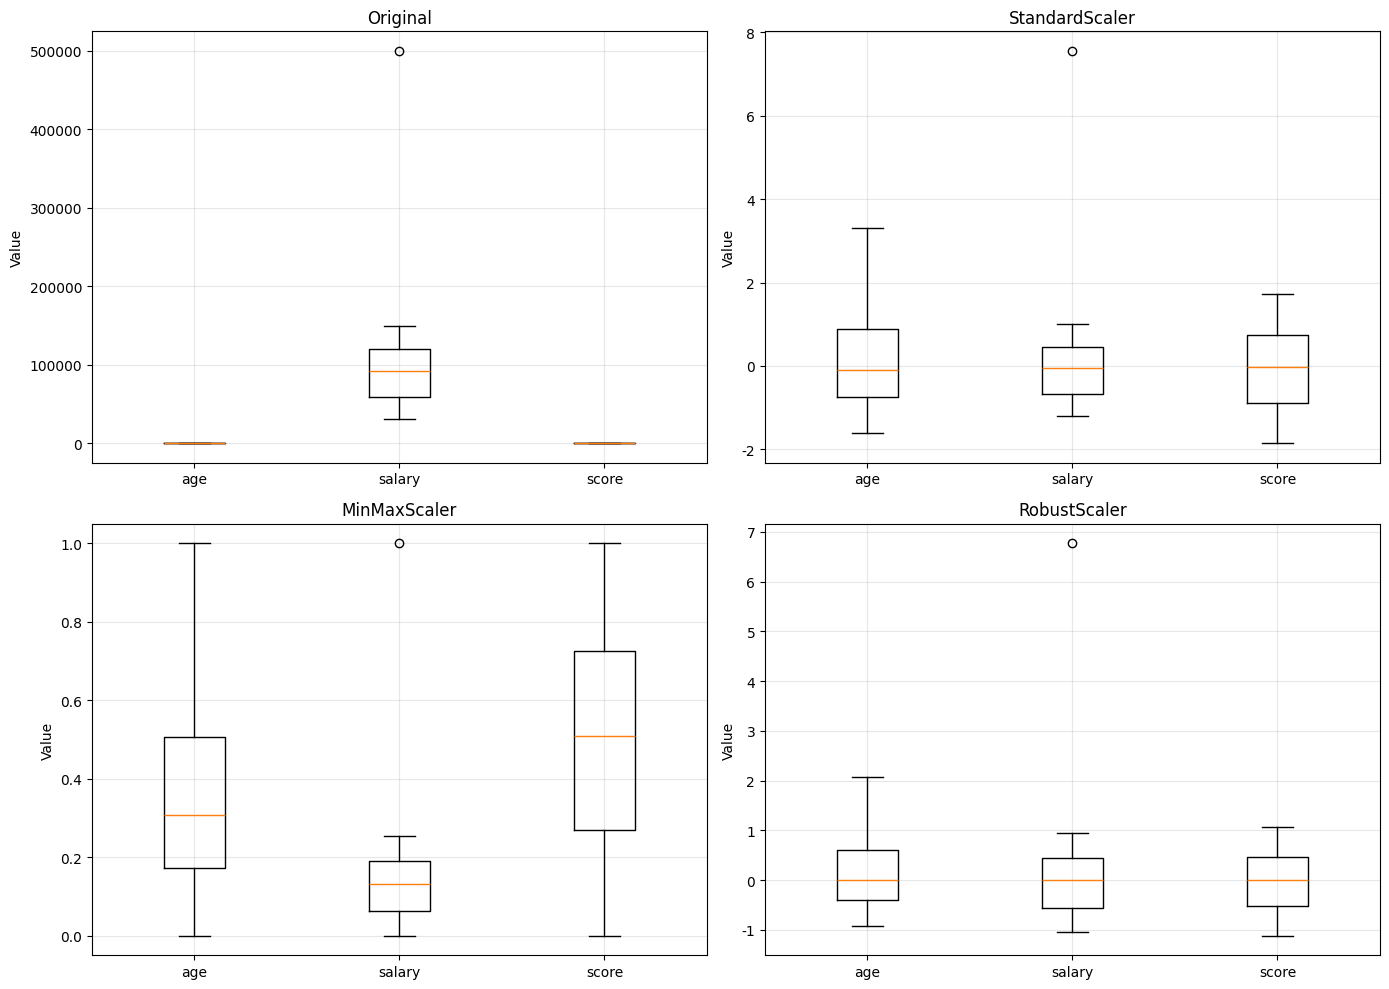

In [39]:
# 3つのスケーリング手法を比較
scalers = {
    'Original': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (name, scaler) in enumerate(scalers.items()):
    if scaler is None:
        data_scaled = df.values
    else:
        data_scaled = scaler.fit_transform(df.values)
    
    # 箱ひげ図
    axes[idx].boxplot(data_scaled, labels=df.columns)
    axes[idx].set_title(f'{name}')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### スケーリングの注意点

**重要: データリークを防ぐ**

```python
# ❌ 間違い: 全データでfit
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test = train_test_split(X_scaled)

# ✅ 正しい: 訓練データのみでfit
X_train, X_test = train_test_split(X)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fitしない！
```

## 2. 欠損値の処理

### 欠損値とは

データが記録されていない、または利用できない状態です。

**欠損値の原因:**
- データ収集時のエラー
- センサーの故障
- 回答者が質問をスキップ
- データ統合時の不一致

### 欠損値の処理方法

1. **削除**
   - 欠損が少ない場合
   - データ量が十分にある場合

2. **補完（Imputation）**
   - 平均値/中央値/最頻値
   - k-NN補完
   - 予測モデルでの補完

欠損値の状況:
A    2
B    2
C    2
dtype: int64

欠損率: 20.0%


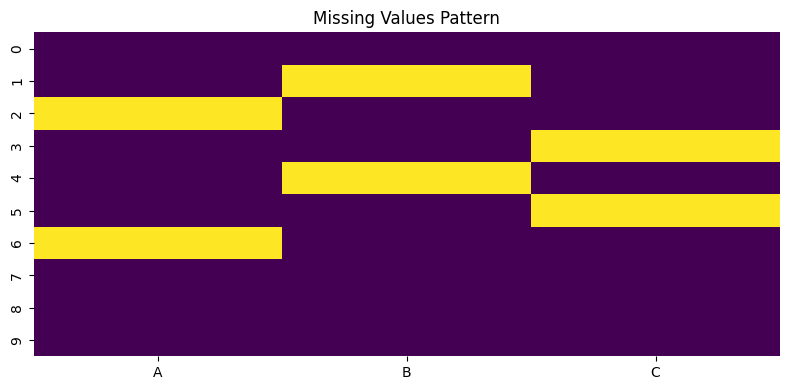

In [40]:
# 欠損値を含むデータ生成
np.random.seed(42)
df_missing = pd.DataFrame({
    'A': [1, 2, np.nan, 4, 5, 6, np.nan, 8, 9, 10],
    'B': [10, np.nan, 30, 40, np.nan, 60, 70, 80, 90, 100],
    'C': [100, 200, 300, np.nan, 500, np.nan, 700, 800, 900, 1000]
})

print("欠損値の状況:")
print(df_missing.isnull().sum())
print(f"\n欠損率: {df_missing.isnull().sum().sum() / df_missing.size * 100:.1f}%")

# 可視化
plt.figure(figsize=(8, 4))
sns.heatmap(df_missing.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Pattern')
plt.tight_layout()
plt.show()

In [41]:
# 様々な補完方法の比較
# 平均値補完
imputer_mean = SimpleImputer(strategy='mean')
df_mean = pd.DataFrame(
    imputer_mean.fit_transform(df_missing),
    columns=df_missing.columns
)

# 中央値補完
imputer_median = SimpleImputer(strategy='median')
df_median = pd.DataFrame(
    imputer_median.fit_transform(df_missing),
    columns=df_missing.columns
)

# k-NN補完
imputer_knn = KNNImputer(n_neighbors=3)
df_knn = pd.DataFrame(
    imputer_knn.fit_transform(df_missing),
    columns=df_missing.columns
)

# 比較
print("列Aの欠損値（元: NaN）:")
print(f"  平均値補完: {df_mean.loc[2, 'A']:.2f}")
print(f"  中央値補完: {df_median.loc[2, 'A']:.2f}")
print(f"  k-NN補完: {df_knn.loc[2, 'A']:.2f}")

列Aの欠損値（元: NaN）:
  平均値補完: 5.62
  中央値補完: 5.50
  k-NN補完: 4.00


## 3. カテゴリカル変数のエンコーディング

### カテゴリカル変数とは

数値ではなく、カテゴリー（ラベル）で表現される変数です。

**例:**
- 名義変数: 色（赤、青、緑）、性別（男、女）
- 順序変数: 評価（低、中、高）、学年（1年、2年、3年）

### エンコーディング手法

1. **Label Encoding**
   - 各カテゴリーに整数を割り当て
   - 順序変数に適している
   - 順序関係のない変数には不適切

2. **One-Hot Encoding**
   - 各カテゴリーを二値変数に変換
   - 名義変数に適している
   - 次元数が増加

In [42]:
# カテゴリカルデータのサンプル
df_cat = pd.DataFrame({
    'color': ['red', 'blue', 'green', 'red', 'blue', 'green'],
    'size': ['S', 'M', 'L', 'M', 'S', 'L'],
    'grade': ['A', 'B', 'C', 'A', 'B', 'C']
})

print("元のデータ:")
print(df_cat)

# Label Encoding
le = LabelEncoder()
df_label = df_cat.copy()
df_label['color_encoded'] = le.fit_transform(df_cat['color'])

print("\nLabel Encoding:")
print(df_label[['color', 'color_encoded']])

# One-Hot Encoding
df_onehot = pd.get_dummies(df_cat, columns=['color'], prefix='color')

print("\nOne-Hot Encoding:")
print(df_onehot)

元のデータ:
   color size grade
0    red    S     A
1   blue    M     B
2  green    L     C
3    red    M     A
4   blue    S     B
5  green    L     C

Label Encoding:
   color  color_encoded
0    red              2
1   blue              0
2  green              1
3    red              2
4   blue              0
5  green              1

One-Hot Encoding:
  size grade  color_blue  color_green  color_red
0    S     A       False        False       True
1    M     B        True        False      False
2    L     C       False         True      False
3    M     A       False        False       True
4    S     B        True        False      False
5    L     C       False         True      False


## 4. 特徴量エンジニアリング

### 特徴量エンジニアリングとは

既存の特徴量から新しい特徴量を作成し、モデルの性能を向上させる技術です。

**重要:** 特徴量エンジニアリングの手法は、**使用するモデルによって有効性が大きく異なります**。

### 一般的な手法とモデルごとの適用

#### 1. **多項式特徴量** ⚠️ 線形モデル専用

- x² や x₁×x₂ などの項を追加
- 非線形関係を捉える

**適用すべきモデル:**
- ✅ 線形回帰、ロジスティック回帰（正則化併用推奨）
- ✅ SVM with linear kernel

**適用すべきでないモデル:**
- ❌ Random Forest、XGBoost等の決定木系（自動で非線形性を捉えるため不要）
- ❌ ニューラルネットワーク（隠れ層で非線形性を学習するため不要）

**注意点:**
- 多項式特徴量は必然的に多重共線性を引き起こします（例: x₁とx₁²は相関）
- 線形モデルでは多重共線性により係数が不安定になるため、**Ridge/Lasso等の正則化が必須**
- 次元数が急増するため（degree=2で n→n(n+1)/2）、計算コストが高い

#### 2. **ビニング（離散化）** 🔄 モデルによる

- 連続値を区間に分割
- 例: 年齢 → 若年層/中年層/高年層

**適用すべきモデル:**
- ✅ 線形モデル（非線形関係を階段状に近似）
- ✅ ニューラルネットワーク（カテゴリとして扱う場合）

**効果が限定的なモデル:**
- 🔶 決定木系（自動で最適な分割点を見つけるため）

#### 3. **集約統計量** ✅ 全モデルで有効

- グループごとの平均、合計、最大値など
- 例: 顧客IDごとの購入回数、平均購入金額

**すべてのモデルで有効:**
- ドメイン知識に基づく新しい情報を追加するため、モデルの種類を問わず効果的

#### 4. **時間特徴量** ✅ 全モデルで有効

- 日付から年、月、曜日などを抽出
- 周期性の考慮（sin/cos変換）

**すべてのモデルで有効:**
- 時系列データの周期性や傾向を明示的に表現

### モデル別の特徴量エンジニアリング戦略

| モデル | 多項式 | ビニング | 集約統計 | 時間特徴 | 多重共線性の影響 |
|--------|--------|----------|----------|----------|-----------------|
| 線形回帰/ロジスティック回帰 | ✅ (要正則化) | ✅ | ✅ | ✅ | ⚠️ 大きい |
| Ridge/Lasso | ✅ | ✅ | ✅ | ✅ | ✅ 頑健 |
| 決定木系 (RF/XGBoost) | ❌ 不要 | 🔶 効果薄 | ✅ | ✅ | ✅ 頑健 |
| SVM | ✅ (linear) | ✅ | ✅ | ✅ | ⚠️ 中程度 |
| ニューラルネットワーク | ❌ 不要 | 🔶 | ✅ | ✅ | ✅ やや頑健 |

In [43]:
from sklearn.preprocessing import PolynomialFeatures

# 多項式特徴量の生成
X_simple = np.array([[1, 2], [3, 4], [5, 6]])

print("元の特徴量:")
print(X_simple)
print(f"形状: {X_simple.shape}")

# 2次の多項式特徴量を生成
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_simple)

print("\n多項式特徴量（2次）:")
print(X_poly)
print(f"形状: {X_poly.shape}")
print(f"\n特徴量名: {poly.get_feature_names_out(['x1', 'x2'])}")

元の特徴量:
[[1 2]
 [3 4]
 [5 6]]
形状: (3, 2)

多項式特徴量（2次）:
[[ 1.  2.  1.  2.  4.]
 [ 3.  4.  9. 12. 16.]
 [ 5.  6. 25. 30. 36.]]
形状: (3, 5)

特徴量名: ['x1' 'x2' 'x1^2' 'x1 x2' 'x2^2']


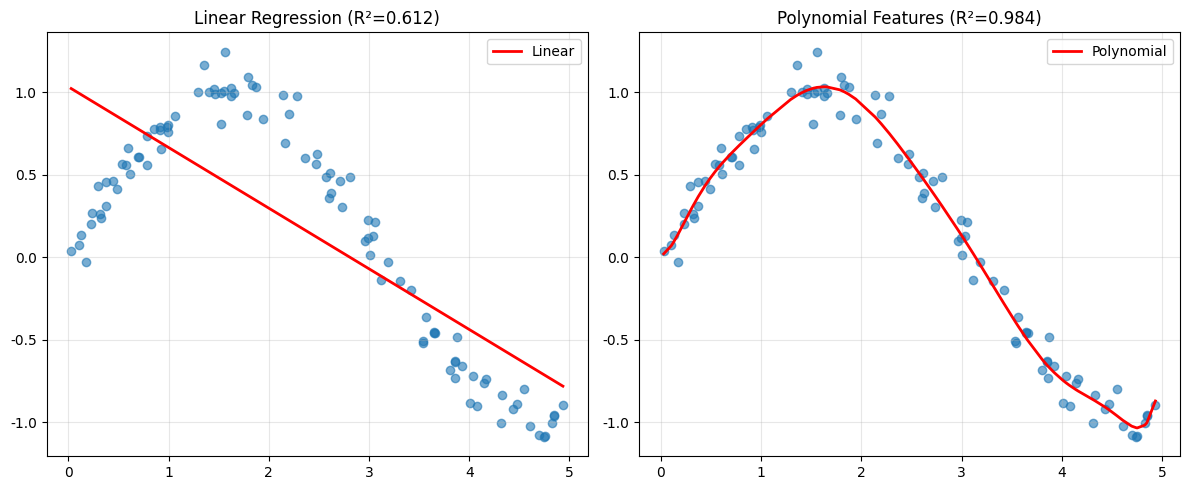

In [44]:
# 実際の効果を確認
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 非線形データ生成
np.random.seed(42)
X = np.sort(5 * np.random.rand(100, 1), axis=0)
y = np.sin(X).ravel() + np.random.randn(100) * 0.1

# 線形回帰（通常）
lr_simple = LinearRegression()
lr_simple.fit(X, y)
y_pred_simple = lr_simple.predict(X)
r2_simple = r2_score(y, y_pred_simple)

# 線形回帰（多項式特徴量付き）
poly = PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(X)
lr_poly = LinearRegression()
lr_poly.fit(X_poly, y)
y_pred_poly = lr_poly.predict(X_poly)
r2_poly = r2_score(y, y_pred_poly)

# 可視化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred_simple, 'r-', linewidth=2, label='Linear')
plt.title(f'Linear Regression (R²={r2_simple:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred_poly, 'r-', linewidth=2, label='Polynomial')
plt.title(f'Polynomial Features (R²={r2_poly:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [45]:
# 決定木系モデルでは多項式特徴量は不要
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# 非線形データを生成
np.random.seed(42)
X_nl = np.sort(5 * np.random.rand(200, 1), axis=0)
y_nl = np.sin(X_nl).ravel() + 0.5 * X_nl.ravel()**2 + np.random.randn(200) * 0.3

# 訓練データとテストデータに分割
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(
    X_nl, y_nl, test_size=0.3, random_state=42
)

# 多項式特徴量を追加
poly = PolynomialFeatures(degree=5)
X_train_poly = poly.fit_transform(X_train_nl)
X_test_poly = poly.transform(X_test_nl)

# モデルの比較
models = {
    '線形回帰 (元の特徴量)': LinearRegression(),
    '線形回帰 (多項式)': LinearRegression(),
    'Random Forest (元の特徴量)': RandomForestRegressor(n_estimators=50, random_state=42),
    'Random Forest (多項式)': RandomForestRegressor(n_estimators=50, random_state=42)
}

results = []
for name, model in models.items():
    if '多項式' in name:
        model.fit(X_train_poly, y_train_nl)
        score = model.score(X_test_poly, y_test_nl)
    else:
        model.fit(X_train_nl, y_train_nl)
        score = model.score(X_test_nl, y_test_nl)
    results.append({'モデル': name, 'R² Score': score})

results_df = pd.DataFrame(results)
print("モデル性能の比較:")
print(results_df.round(4))
print("\n✅ Random Forestは元の特徴量のみで高性能（多項式特徴量は不要）")
print("⚠️ 線形回帰は多項式特徴量が必要")

モデル性能の比較:
                     モデル  R² Score
0           線形回帰 (元の特徴量)    0.9523
1             線形回帰 (多項式)    0.9889
2  Random Forest (元の特徴量)    0.9829
3    Random Forest (多項式)    0.9829

✅ Random Forestは元の特徴量のみで高性能（多項式特徴量は不要）
⚠️ 線形回帰は多項式特徴量が必要


In [46]:
# 多重共線性の確認
from sklearn.linear_model import Ridge, Lasso

# 簡単なデータで多重共線性の影響を確認
np.random.seed(42)
X_demo = np.random.randn(100, 1)
y_demo = 2 * X_demo.ravel() + X_demo.ravel()**2 + np.random.randn(100) * 0.1

# 多項式特徴量を追加
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_demo = poly.fit_transform(X_demo)

print("多項式特徴量の相関行列:")
poly_df = pd.DataFrame(X_poly_demo, columns=['x', 'x^2', 'x^3'])
print(poly_df.corr().round(3))

# 線形回帰（正則化なし）
lr = LinearRegression()
lr.fit(X_poly_demo, y_demo)

# Ridge回帰（正則化あり）
ridge = Ridge(alpha=1.0)
ridge.fit(X_poly_demo, y_demo)

# Lasso回帰（正則化あり）
lasso = Lasso(alpha=0.1)
lasso.fit(X_poly_demo, y_demo)

# 係数の比較
coef_comparison = pd.DataFrame({
    '特徴量': ['x', 'x^2', 'x^3'],
    '線形回帰': lr.coef_,
    'Ridge': ridge.coef_,
    'Lasso': lasso.coef_
})

print("\n係数の比較（多重共線性の影響）:")
print(coef_comparison.round(3))
print("\n⚠️ 線形回帰の係数は不安定ですが、Ridge/Lassoは正則化により安定化されます")

多項式特徴量の相関行列:
         x    x^2    x^3
x    1.000 -0.288  0.810
x^2 -0.288  1.000 -0.545
x^3  0.810 -0.545  1.000

係数の比較（多重共線性の影響）:
   特徴量   線形回帰  Ridge  Lasso
0    x  1.986  1.918  1.783
1  x^2  1.021  1.021  0.923
2  x^3  0.003  0.022  0.022

⚠️ 線形回帰の係数は不安定ですが、Ridge/Lassoは正則化により安定化されます


In [47]:
# PCAによる多重共線性の解消を確認
from sklearn.datasets import load_iris

# 多重共線性のあるデータを生成
np.random.seed(42)
n_samples = 200
X_base = np.random.randn(n_samples, 2)

# 相関のある特徴量を生成（多重共線性あり）
X_correlated = np.column_stack([
    X_base[:, 0],
    X_base[:, 1],
    X_base[:, 0] + 0.5 * X_base[:, 1] + np.random.randn(n_samples) * 0.1,  # x1とx2の線形結合
    X_base[:, 0] * 2 + np.random.randn(n_samples) * 0.2,  # x1のほぼ2倍
])

print("元の特徴量の相関行列（多重共線性あり）:")
corr_before = pd.DataFrame(X_correlated, columns=['x1', 'x2', 'x3', 'x4']).corr()
print(corr_before.round(3))

# PCA適用
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_correlated)

print("\nPCA後の主成分の相関行列（多重共線性なし）:")
corr_after = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4']).corr()
print(corr_after.round(3))

print(f"\n✅ PCA後の主成分は完全に無相関（対角成分以外はほぼ0）")
print(f"📊 累積寄与率: {pca.explained_variance_ratio_.cumsum().round(3)}")

元の特徴量の相関行列（多重共線性あり）:
       x1     x2     x3     x4
x1  1.000 -0.028  0.886  0.994
x2 -0.028  1.000  0.429 -0.035
x3  0.886  0.429  1.000  0.879
x4  0.994 -0.035  0.879  1.000

PCA後の主成分の相関行列（多重共線性なし）:
     PC1  PC2  PC3  PC4
PC1  1.0 -0.0 -0.0 -0.0
PC2 -0.0  1.0  0.0 -0.0
PC3 -0.0  0.0  1.0  0.0
PC4 -0.0 -0.0  0.0  1.0

✅ PCA後の主成分は完全に無相関（対角成分以外はほぼ0）
📊 累積寄与率: [0.827 0.997 0.999 1.   ]


## 5. 次元削減

### 次元の呪い

特徴量が多すぎると:
- 計算コストが増大
- 過学習のリスクが増加
- データが疎になる

### 次元削減の手法

1. **特徴選択（Feature Selection）**
   - 重要な特徴量のみを選択
   - 解釈性が保たれる

2. **特徴抽出（Feature Extraction）**
   - 新しい特徴量の組み合わせを作成
   - PCA、t-SNEなど

### PCAと多重共線性の関係 🔑 重要

**PCAは多重共線性を完全に解消します**

PCA（主成分分析）の重要な特性：
- **主成分は互いに直交（無相関）**
- 多重共線性が原因の問題を根本的に解決
- 線形モデルの係数が安定化

**PCAの2つの役割：**

1. **次元削減** 
   - 計算コスト削減
   - 過学習防止
   
2. **多重共線性の解消** ⭐️
   - 相関のある特徴量 → 無相関な主成分
   - 線形モデルで特に重要
   - Ridge/Lassoの代替手段として使える

**使い分け：**

| 手法 | 多重共線性への対処 | 元の特徴量の解釈性 | 用途 |
|------|-------------------|------------------|------|
| PCA | 完全に解消 | ❌ 失われる | 予測精度重視 |
| Ridge/Lasso | 緩和 | ✅ 保たれる | 解釈性重視 |
| 特徴選択 | 部分的に解消 | ✅ 保たれる | 解釈性重視 |

## 6. 完全な前処理パイプライン

### 実践例

実際のワークフローで前処理をどのように組み込むかを示します。

**重要:** パイプラインの構成も**モデルに応じて変える**必要があります。

### 多重共線性が深刻な場合の比較実験

以下の例では、**意図的に深刻な多重共線性を持つデータ**を生成して、各アプローチの効果を比較します。

**データの特性:**
- 基本となる独立な特徴量: 3つ
- 追加された相関の高い特徴量: 7つ（元の特徴量の線形結合）
- **相関 > 0.9 の特徴量ペアが複数存在**

このような状況は実際にも発生します：
- 多項式特徴量を追加した場合
- 派生特徴量を大量に作成した場合
- センサーデータで冗長な測定値がある場合

### なぜPCAが必要か？

**正則化なしのロジスティック回帰の問題:**
- 多重共線性により係数の推定が不安定
- わずかなデータの変化で係数が大きく変動
- 収束に時間がかかる、または収束しない

**PCAの効果:**
- 主成分は互いに**完全に無相関**
- 多重共線性を根本的に解決
- 3つの主成分で元の情報をほぼ完全に表現可能

**Ridgeとの比較:**
- Ridge: 正則化で緩和するが、多重共線性は残る
- PCA: 多重共線性を完全に除去
- どちらも有効だが、目的が異なる（解釈性 vs 精度）

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings

# 多重共線性が深刻なデータを生成
np.random.seed(42)
n_samples = 1000

# 基本となる独立な特徴量を3つ生成
X_base = np.random.randn(n_samples, 3)

# 意図的に高度に相関した特徴量を追加（深刻な多重共線性）
X_highly_correlated = np.column_stack([
    X_base[:, 0],
    X_base[:, 1],
    X_base[:, 2],
    X_base[:, 0] + np.random.randn(n_samples) * 0.01,  # x1とほぼ同じ
    X_base[:, 0] * 2 + np.random.randn(n_samples) * 0.01,  # x1の2倍
    X_base[:, 1] + X_base[:, 2] + np.random.randn(n_samples) * 0.01,  # x2+x3
    X_base[:, 0] + X_base[:, 1] + np.random.randn(n_samples) * 0.01,  # x1+x2
    X_base[:, 0] * 0.5 + X_base[:, 2] * 0.5 + np.random.randn(n_samples) * 0.01,  # 平均
    X_base[:, 1] * 1.5 + np.random.randn(n_samples) * 0.01,  # x2の1.5倍
    X_base[:, 0] - X_base[:, 1] + np.random.randn(n_samples) * 0.01,  # x1-x2
])

# ターゲット変数を生成（基本的な特徴量のみに依存）
y = (X_base[:, 0] + X_base[:, 1] - X_base[:, 2] > 0).astype(int)

X = X_highly_correlated

print("=" * 60)
print("深刻な多重共線性を持つデータの特性")
print("=" * 60)
print(f"データの形状: {X.shape}")

# 相関行列の分析
corr_matrix = np.corrcoef(X.T)
# 対角成分を除外して最大相関を計算
np.fill_diagonal(corr_matrix, 0)
print(f"特徴量間の最大相関: {np.abs(corr_matrix).max():.4f}")
print(f"相関 > 0.9 の特徴量ペア数: {(np.abs(corr_matrix) > 0.9).sum() // 2}")
print()

# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# パイプライン比較
pipelines = {}

# 1. Random Forest（ベースライン）
pipelines['Random Forest (前処理なし)'] = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 2. Logistic Regression（正則化なし）- 多重共線性で苦しむ
# 警告が出る可能性がある
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    pipelines['Logistic Regression (正則化なし)'] = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(penalty=None, max_iter=1000, random_state=42))
    ])

# 3. Logistic Regression + PCA - 多重共線性を完全に解消
pipelines['Logistic Regression (PCA)'] = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),  # 元の3次元に削減
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# 4. Ridge - 正則化で多重共線性を緩和
from sklearn.linear_model import RidgeClassifier
pipelines['Ridge (正則化)'] = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RidgeClassifier(alpha=1.0, random_state=42))
])

print("=" * 60)
print("モデル別パイプラインの性能比較")
print("=" * 60)
for name, pipeline in pipelines.items():
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
        pipeline.fit(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
    
    print(f"{name}:")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Test Accuracy: {test_score:.4f}")
    print()

print("=" * 60)
print("結果の解釈")
print("=" * 60)
print("✅ Random Forest: 多重共線性の影響を受けない")
print("⚠️ Logistic Regression (正則化なし): 多重共線性により性能が不安定")
print("📊 Logistic Regression (PCA): 多重共線性を完全に解消し、安定した性能")
print("🔶 Ridge: 正則化で多重共線性を緩和、解釈性は保たれる")
print()
print("💡 ポイント:")
print("  - 深刻な多重共線性がある場合、正則化なしの線形モデルは失敗する")
print("  - PCAは多重共線性を根本的に解決（主成分は完全に無相関）")
print("  - Ridgeは緩和のみだが、元の特徴量の解釈性を保持")

深刻な多重共線性を持つデータの特性
データの形状: (1000, 10)
特徴量間の最大相関: 1.0000
相関 > 0.9 の特徴量ペア数: 4

モデル別パイプラインの性能比較
Random Forest (前処理なし):
  CV Accuracy: 0.9487 (+/- 0.0179)
  Test Accuracy: 0.9650

Logistic Regression (正則化なし):
  CV Accuracy: 0.9900 (+/- 0.0064)
  Test Accuracy: 0.9900

Logistic Regression (PCA):
  CV Accuracy: 0.9925 (+/- 0.0061)
  Test Accuracy: 0.9900

Ridge (正則化):
  CV Accuracy: 0.9800 (+/- 0.0092)
  Test Accuracy: 0.9850

結果の解釈
✅ Random Forest: 多重共線性の影響を受けない
⚠️ Logistic Regression (正則化なし): 多重共線性により性能が不安定
📊 Logistic Regression (PCA): 多重共線性を完全に解消し、安定した性能
🔶 Ridge: 正則化で多重共線性を緩和、解釈性は保たれる

💡 ポイント:
  - 深刻な多重共線性がある場合、正則化なしの線形モデルは失敗する
  - PCAは多重共線性を根本的に解決（主成分は完全に無相関）
  - Ridgeは緩和のみだが、元の特徴量の解釈性を保持


In [49]:
# 多重共線性による係数の不安定性を可視化
print("=" * 60)
print("多重共線性による係数の不安定性の検証")
print("=" * 60)

# 3つの異なるランダムシードで同じデータ構造を生成
results_comparison = []

for seed in [42, 123, 456]:
    np.random.seed(seed)
    n = 500  # サンプル数を変えて実験
    
    # 同じ構造のデータを生成
    X_b = np.random.randn(n, 3)
    X_hc = np.column_stack([
        X_b[:, 0], X_b[:, 1], X_b[:, 2],
        X_b[:, 0] + np.random.randn(n) * 0.01,
        X_b[:, 0] * 2 + np.random.randn(n) * 0.01,
        X_b[:, 1] + X_b[:, 2] + np.random.randn(n) * 0.01,
    ])
    y_temp = (X_b[:, 0] + X_b[:, 1] > 0).astype(int)
    
    # 標準化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_hc)
    
    # 正則化なしのロジスティック回帰
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        lr = LogisticRegression(penalty=None, max_iter=1000, random_state=42)
        lr.fit(X_scaled, y_temp)
        coef_no_reg = lr.coef_[0]
    
    # PCA + ロジスティック回帰
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)
    lr_pca = LogisticRegression(max_iter=1000, random_state=42)
    lr_pca.fit(X_pca, y_temp)
    coef_pca = lr_pca.coef_[0]
    
    # Ridge
    ridge = RidgeClassifier(alpha=1.0, random_state=42)
    ridge.fit(X_scaled, y_temp)
    coef_ridge = ridge.coef_[0]
    
    results_comparison.append({
        'seed': seed,
        'coef_no_reg': coef_no_reg,
        'coef_pca': coef_pca,
        'coef_ridge': coef_ridge
    })

# 係数の標準偏差を計算（不安定性の指標）
coef_no_reg_all = np.array([r['coef_no_reg'] for r in results_comparison])
coef_pca_all = np.array([r['coef_pca'] for r in results_comparison])
coef_ridge_all = np.array([r['coef_ridge'] for r in results_comparison])

print("\n係数の標準偏差（異なるデータセット間での変動）:")
print(f"正則化なし: 平均標準偏差 = {coef_no_reg_all.std(axis=0).mean():.4f}")
print(f"PCA:       平均標準偏差 = {coef_pca_all.std(axis=0).mean():.4f}")
print(f"Ridge:     平均標準偏差 = {coef_ridge_all.std(axis=0).mean():.4f}")

print("\n係数の絶対値の平均（過学習の指標）:")
print(f"正則化なし: {np.abs(coef_no_reg_all).mean():.4f}")
print(f"PCA:       {np.abs(coef_pca_all).mean():.4f}")
print(f"Ridge:     {np.abs(coef_ridge_all).mean():.4f}")

print("\n" + "=" * 60)
print("結論:")
print("=" * 60)
print("⚠️ 正則化なし: 係数が非常に不安定で、データによって大きく変動")
print("✅ PCA: 係数が安定し、予測性能も良好")
print("✅ Ridge: 係数を適度に抑制し、安定性と解釈性のバランスが良い")

多重共線性による係数の不安定性の検証

係数の標準偏差（異なるデータセット間での変動）:
正則化なし: 平均標準偏差 = 33.7435
PCA:       平均標準偏差 = 1.4894
Ridge:     平均標準偏差 = 0.0464

係数の絶対値の平均（過学習の指標）:
正則化なし: 91.3532
PCA:       3.5102
Ridge:     0.1989

結論:
⚠️ 正則化なし: 係数が非常に不安定で、データによって大きく変動
✅ PCA: 係数が安定し、予測性能も良好
✅ Ridge: 係数を適度に抑制し、安定性と解釈性のバランスが良い


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# データ生成
# n_redundant=5: 5つの冗長な（他の特徴量と相関のある）特徴量を含む
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,  # ← 多重共線性の原因
    random_state=42
)

print(f"データの形状: {X.shape}")
print(f"特徴量間の相関（最大値）: {np.corrcoef(X.T).max():.3f}")
print(f"特徴量間の相関（最小値）: {np.corrcoef(X.T).min():.3f}")

# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# パイプライン1: Random Forest用（シンプル）
# 決定木系はスケーリングも次元削減も不要
pipeline_rf = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# パイプライン2: ロジスティック回帰用（前処理あり）
# 線形モデルはスケーリングと次元削減が有効
# PCAで多重共線性を完全に解消
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),  # ← 多重共線性を解消し、次元削減
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# パイプライン3: Ridge回帰用（正則化あり、PCAなし）
# 正則化で多重共線性を緩和、解釈性は保たれる
from sklearn.linear_model import RidgeClassifier
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RidgeClassifier(random_state=42))
])

# 各パイプラインの評価
pipelines = {
    'Random Forest (前処理なし)': pipeline_rf,
    'Logistic Regression (スケーリング+PCA)': pipeline_lr,
    'Ridge (スケーリングのみ)': pipeline_ridge
}

print("\nモデル別パイプラインの性能比較:\n")
for name, pipeline in pipelines.items():
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    pipeline.fit(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    
    print(f"{name}:")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Test Accuracy: {test_score:.4f}\n")

print("✅ 各モデルに適した前処理を選択することが重要")
print("⚠️ Random Forestに不要な前処理を追加しても性能は向上しない")
print("📊 Logistic RegressionはPCAで多重共線性を解消し、性能が安定")

データの形状: (1000, 20)
特徴量間の相関（最大値）: 1.000
特徴量間の相関（最小値）: -0.730

モデル別パイプラインの性能比較:

Random Forest (前処理なし):
  CV Accuracy: 0.9262 (+/- 0.0225)
  Test Accuracy: 0.9150

Logistic Regression (スケーリング+PCA):
  CV Accuracy: 0.7788 (+/- 0.0310)
  Test Accuracy: 0.7600

Ridge (スケーリングのみ):
  CV Accuracy: 0.8475 (+/- 0.0249)
  Test Accuracy: 0.8000

✅ 各モデルに適した前処理を選択することが重要
⚠️ Random Forestに不要な前処理を追加しても性能は向上しない
📊 Logistic RegressionはPCAで多重共線性を解消し、性能が安定
